# PASCAL VOC Translation Experiments

Make synthetic "video" dataset of a translating viewpoint from PASCAL VOC images and groundtruth to evaluate pipeline and clockwork methods.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from collections import namedtuple

import caffe

from lib import run_net
from lib import score_util

from datasets.pascal_voc import pascal

PV = pascal('/x/PASCAL/VOC2011')
valset = PV.get_dset()

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (12, 12)

Configure Caffe

In [2]:
caffe.set_device(0)
caffe.set_mode_gpu()

Check translated frames and boundaries.

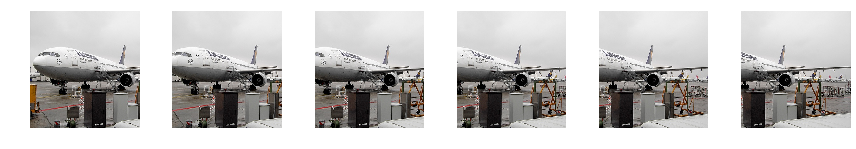

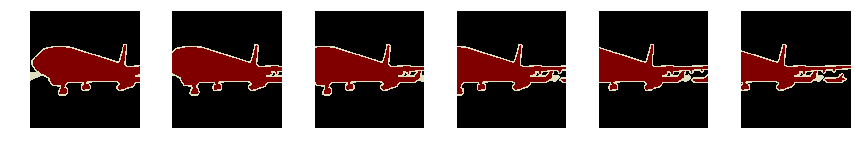

In [3]:
idx = valset[0]
im, label = PV.load_image(idx), PV.load_label(idx)

im_t, label_t = PV.make_translated_frames(im, label, shift=32, num_frames=6)

plt.figure()
for i, im in enumerate(im_t):
    plt.subplot(1, len(im_t), i + 1)
    plt.imshow(im)
    plt.axis('off')
    plt.tight_layout()
plt.figure()
for i, label in enumerate(label_t):
    plt.subplot(1, len(label_t), i + 1)
    plt.imshow(PV.palette(label))
    plt.axis('off')
    plt.tight_layout()

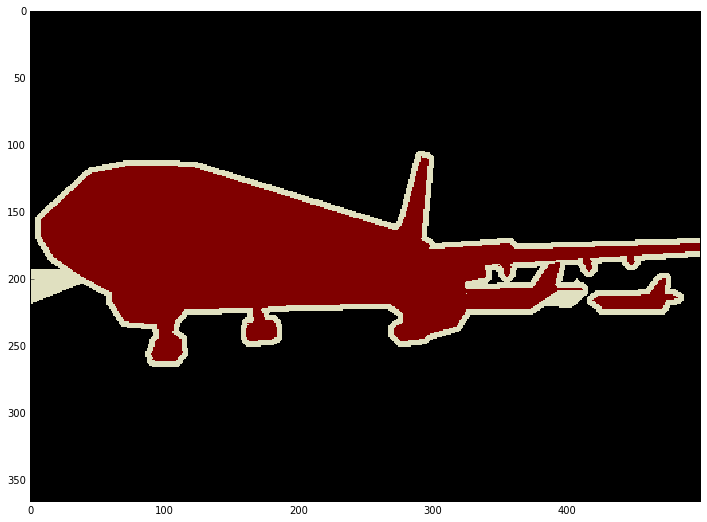

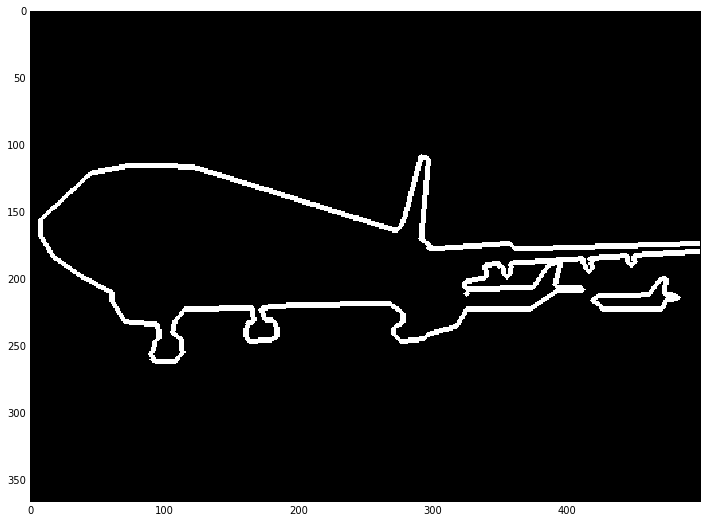

In [4]:
idx = valset[0]
label = PV.load_label(idx)
bdry = PV.make_boundaries(label, thickness=2)

plt.figure()
plt.imshow(PV.palette(label))
plt.figure()
plt.imshow(bdry)

## Evaluation

Configure evaluation: number of classes, length of translation "video" in frames, boundary thickness, and amounts of shift, plus the catalogue of methods.

In [5]:
n_cl = len(PV.classes)
num_frames = 6
thickness = 5
shifts = (16, 32)

# catalogue methods: the full FCN, truncated FCNs for pool3 and pool4, and the 2 and 3 stage pipelines
# instantiate the nets that will be needed
Method = namedtuple('Method', 'method arch weights infer_func, input_offset')
fcn = Method('fcn', '../nets/voc-fcn8s.prototxt', '../nets/voc-fcn8s-heavy.caffemodel', run_net.segrun, 2)
baseline_3stage = Method('baseline_3stage', '../nets/voc-fcn-pool3.prototxt', '../nets/voc-fcn-pool3.caffemodel', run_net.segrun, 2)
baseline_2stage = Method('baseline_2stage', '../nets/voc-fcn-pool4.prototxt', '../nets/voc-fcn-pool4.caffemodel', run_net.segrun, 2)
pipeline_3stage = Method('pipeline_3stage', '../nets/stage-voc-fcn8s.prototxt', '../nets/voc-fcn8s-heavy.caffemodel', run_net.pipeline_3stage_forward, 0)
pipeline_2stage = Method('pipeline_2stage', '../nets/stage-voc-fcn8s.prototxt', '../nets/voc-fcn8s-heavy.caffemodel', run_net.pipeline_2stage_forward, 1)

In [6]:
def score_translations(method, shift, arch, weights, infer, offset):
    """
    Score the translated "video" of PASCAL VOC seg11valid images
    taking care of the net architecture and weights, the particular inference method,
    and the input offset needed to align every frame and pipeline methods.
    """
    net = caffe.Net(arch, weights, caffe.TEST)
    hist, hist_b = np.zeros((n_cl, n_cl)), np.zeros((n_cl, n_cl))
    for idx in valset:
        sys.stdout.flush()
        im, label = PV.load_image(idx), PV.load_label(idx)
        im_frames, label_frames = PV.make_translated_frames(im, label, shift=shift, num_frames=num_frames)
        im_frames, label_frames = im_frames[offset:], label_frames[offset:]
        # prepare pipelines: feed initial inputs then skip accordingly
        if method == 'pipeline_3stage':
            run_net.pipeline_fill_3stage(net, PV.preprocess(im_frames[0]), PV.preprocess(im_frames[1]))
            im_frames, label_frames = im_frames[2:], label_frames[2:]
        elif method == 'pipeline_2stage':
            run_net.pipeline_fill_2stage(net, PV.preprocess(im_frames[0]))
            im_frames, label_frames = im_frames[1:], label_frames[1:]
        for im_t, label_t in zip(im_frames, label_frames):
            out = infer(net, PV.preprocess(im_t))
            hist += score_util.score_out_gt(out, label_t, n_cl=n_cl)
            bdry = PV.make_boundaries(label_t, thickness=thickness)
            hist_b += score_util.score_out_gt_bdry(out, label_t, bdry, n_cl=n_cl)

    for name, h in zip(('seg', 'bdry'), (hist, hist_b)):
        accP, cl_accP, mean_iuP, fw_iuP = score_util.get_scores(h)
        print '{}: {}, shift {}'.format(method, name, shift)
        print 'acc\t\t cl acc\t\t mIU\t\t fwIU'
        print '{:f}\t {:f}\t {:f}\t {:f}\t'.format(100*accP, 100*cl_accP, 100*mean_iuP, 100*fw_iuP)

for shift in shifts:
    for m in (fcn, baseline_3stage, pipeline_3stage, baseline_2stage, pipeline_2stage):
        score_translations(m.method, shift, m.arch, m.weights, m.infer_func, m.input_offset)

fcn: seg, shift 16
acc		 cl acc		 mIU		 fwIU
90.687921	 77.251232	 65.906854	 83.567673	
fcn: bdry, shift 16
acc		 cl acc		 mIU		 fwIU
66.928887	 65.314371	 56.977800	 56.233177	
baseline_3stage: seg, shift 16
acc		 cl acc		 mIU		 fwIU
68.854711	 13.860394	 9.271018	 54.765414	
baseline_3stage: bdry, shift 16
acc		 cl acc		 mIU		 fwIU
18.967217	 12.557868	 6.166132	 9.499927	
pipeline_3stage: seg, shift 16
acc		 cl acc		 mIU		 fwIU
86.757968	 70.672165	 57.170321	 77.393265	
pipeline_3stage: bdry, shift 16
acc		 cl acc		 mIU		 fwIU
53.885086	 53.049027	 45.666639	 44.064531	
baseline_2stage: seg, shift 16
acc		 cl acc		 mIU		 fwIU
77.187313	 31.455888	 22.528362	 64.713989	
baseline_2stage: bdry, shift 16
acc		 cl acc		 mIU		 fwIU
34.376393	 24.328654	 16.658117	 21.937302	
pipeline_2stage: seg, shift 16
acc		 cl acc		 mIU		 fwIU
89.537623	 75.274789	 63.290430	 81.685134	
pipeline_2stage: bdry, shift 16
acc		 cl acc		 mIU		 fwIU
61.279158	 60.258576	 52.315699	 50.943556	
fcn: seg, sh